# backtesting with grid search using fastquant

## backtest SMAC

`fastquant` offers a convenient way to backtest several trading strategies. To backtest using Simple Moving Average Crossover (`SMAC`), we do the following.

```python
backtest('smac', dcv_data, fast_period=15, slow_period=40)
```

`fast_period` and `slow_period` are two `SMAC` parameters that can be changed depending on the user's preferences. A simple way to fine tune these parameters is to run `backtest` on a grid of values and find which combination of `fast_period` and `slow_period` yields the highest net profit.

First, we fetch `JFC`'s historical data comprised of date, close price, and volume.

In [1]:
from fastquant import get_stock_data, backtest

symbol='JFC'
dcv_data = get_stock_data(symbol, 
                    start_date='2018-01-01', 
                    end_date='2020-04-28',
                    format='dcv',
                    #save=True
                   )
dcv_data.head()

,dt,close,volume
0,2018-01-03,255.4,745780
1,2018-01-04,255.0,617010
2,2018-01-05,255.0,946040
3,2018-01-08,256.0,840630
4,2018-01-09,255.8,978180


Second, we specify the range of reasonable values to explore for `fast_period` and `slow_period`. Let's take between 1 and 20 trading days (roughly a month) in steps of 1 day for `fast_period`, and between 21 and 240 trading days (roughly a year) in steps of 5 days for `slow_period`.

## define the search space

In [2]:
import numpy as np

fast_periods = np.arange(1,20,1)
slow_periods = np.arange(20,241,5)

# make a grid of 0's (placeholder)
period_grid = np.zeros(shape=(len(fast_periods),len(slow_periods)))
period_grid.shape

(19, 45)

Third, we run backtest for each iteration over each pair of `fast_period` and `slow_period`, saving each time the net profit to the `period_grid` variable.

Note: Before running backtest over a large grid, try measuring how long it takes your machine to run one backtest instance.
```python
%timeit
backtest(...)
```

## run grid search

In [3]:
init_cash=100000

for i,fast_period in enumerate(fast_periods): 
    for j,slow_period in enumerate(slow_periods):
        cerebro = backtest('smac', 
                           dcv_data, 
                           fast_period=fast_period,
                           slow_period=slow_period,
                           init_cash=100000,
                           verbose=False, 
                           plot=False
                          )
        net_profit = cerebro.broker.getvalue()-init_cash
        period_grid[i,j] = net_profit

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 20
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 25
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 30
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 35
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 40
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 45
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 1
slow_period : 50
===Global level arguments==

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 100
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 105
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 110
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 115
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 120
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 125
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 2
slow_period : 130
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 180
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 185
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 190
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 195
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 200
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 205
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 210
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 25
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 30
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 35
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 40
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 45
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 50
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 5
slow_period : 55
===Global level arguments==

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 100
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 105
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 110
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 115
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 120
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 125
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 6
slow_period : 130
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 170
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 175
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 180
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 185
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 190
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 195
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 7
slow_period : 200
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 20
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 25
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 30
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 35
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 40
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 45
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 9
slow_period : 50
===Global level arguments==

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 100
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 105
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 110
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 115
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 120
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 125
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 10
slow_period : 130
===Global lev

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 175
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 180
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 185
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 190
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 195
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 200
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 11
slow_period : 205
===Global lev

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 30
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 35
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 40
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 45
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 50
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 55
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 13
slow_period : 60
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 105
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 110
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 115
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 120
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 125
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 130
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 14
slow_period : 135
===Global lev

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 180
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 185
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 190
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 195
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 200
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 205
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 15
slow_period : 210
===Global lev

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 35
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 40
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 45
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 50
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 55
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 60
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 17
slow_period : 65
===Global level argu

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 110
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 115
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 120
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 125
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 130
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 135
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 18
slow_period : 140
===Global lev

===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 185
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 190
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 195
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 200
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 205
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 210
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 19
slow_period : 215
===Global lev

## visualize the period grid

Next, we visualize `period_grid` as a 2D matrix.

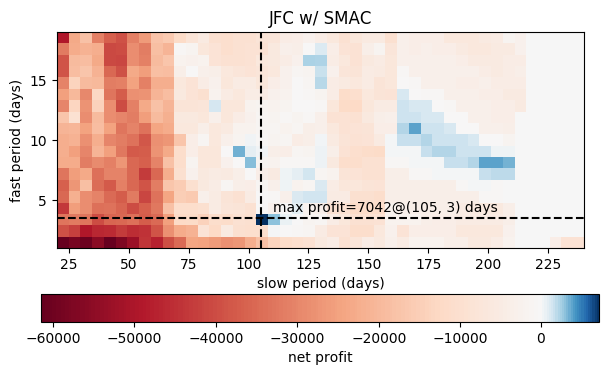

In [16]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

fig, ax = pl.subplots(1,1, figsize=(8,4))
xmin, xmax = slow_periods[0],slow_periods[-1]
ymin, ymax = fast_periods[0],fast_periods[-1]

#make a diverging color map such that profit<0 is red and blue otherwise
cmap = pl.get_cmap('RdBu')
norm = mcolors.DivergingNorm(vmin=period_grid.min(), 
                             vmax = period_grid.max(), 
                             vcenter=0
                            )
#plot matrix
cbar = ax.imshow(period_grid, 
                 origin='lower', 
                 interpolation='none', 
                 extent=[xmin, xmax, ymin, ymax], 
                 cmap=cmap,
                 norm=norm
                )
pl.colorbar(cbar, ax=ax, shrink=0.9,
            label='net profit', orientation="horizontal")

# search position with highest net profit
y, x = np.unravel_index(np.argmax(period_grid), period_grid.shape)
best_slow_period = slow_periods[x]
best_fast_period = fast_periods[y]
# mark position
ax.annotate(f"max profit={period_grid[y, x]:.0f}@({best_slow_period}, {best_fast_period}) days", 
            (best_slow_period+5,best_fast_period+1)
           )
ax.axvline(best_slow_period, 0, 1, c='k', ls='--')
ax.axhline(best_fast_period+0.5, 0, 1, c='k', ls='--')

# add labels
ax.set_aspect(5)
pl.setp(ax,
        xlim=(xmin,xmax),
        ylim=(ymin,ymax),
        xlabel='slow period (days)',
        ylabel='fast period (days)',
        title='JFC w/ SMAC',
       );

From the plot above, there are only a few period combinations which we can guarantee non-negative net profit using SMAC strategy. The best result is achieved with (105,30) for period_slow and period_fast, respectively.

In fact SMAC strategy is so bad such that there is only 9% chance it will yield profit when using any random period combinations in our grid, which is smaller than the 12% chance it will yield break even at least.

In [28]:
percent_positive_profit=(period_grid>0).sum()/np.product(period_grid.shape)*100
percent_positive_profit

9.005847953216374

In [29]:
percent_breakeven=(period_grid==0).sum()/np.product(period_grid.shape)*100
percent_breakeven

12.397660818713451

Anyway, let's check the results of backtest using the `best_fast_period` and `best_slow_period`.

Starting Portfolio Value: 100000.00
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
===Strategy level arguments===
fast_period : 3
slow_period : 105
2018-08-22, BUY CREATE, 286.00
2018-08-22, Cash: 100000.0
2018-08-22, Price: 286.0
2018-08-22, Buy prop size: 346
2018-08-22, Afforded size: 346
2018-08-22, Final size: 346
2018-08-23, BUY EXECUTED, Price: 286.00, Cost: 98956.00, Comm 742.17
2018-09-12, SELL CREATE, 277.00
2018-09-13, SELL EXECUTED, Price: 277.00, Cost: 98956.00, Comm 718.81
2018-09-13, OPERATION PROFIT, GROSS -3114.00, NET -4574.98
2018-10-23, BUY CREATE, 268.00
2018-10-23, Cash: 95425.015
2018-10-23, Price: 268.0
2018-10-23, Buy prop size: 353
2018-10-23, Afforded size: 353
2018-10-23, Final size: 353
2018-10-24, BUY EXECUTED, Price: 268.00, Cost: 94604.00, Comm 709.53
2018-10-25, SELL CREATE, 270.00
2018-10-26, SELL EXECUTED, Price: 270.00, Cost: 94604.00, Comm 714.83
2018-10-26, OPERATION PROFIT, GROSS 706.00, NET -718.36
2018-10-30, BUY CREA

<IPython.core.display.Javascript object>


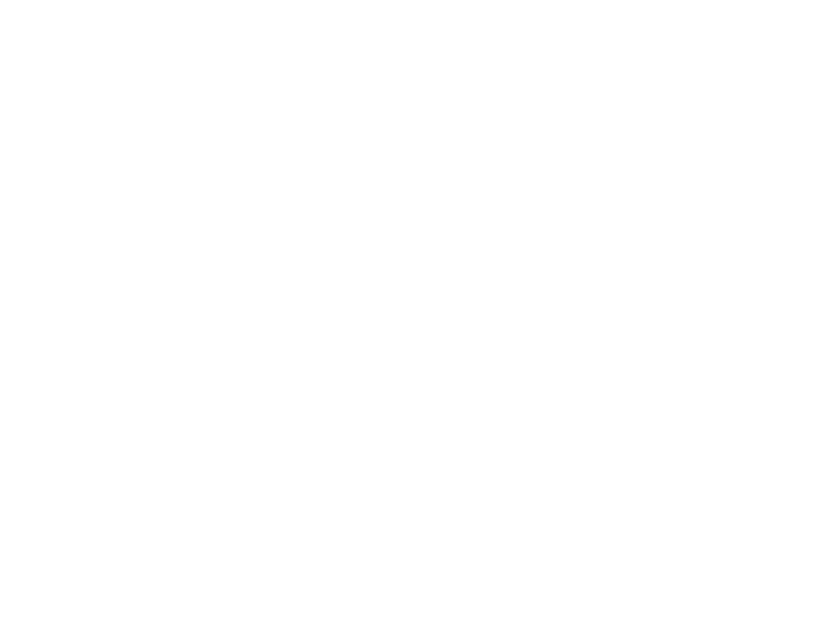

107042.0225

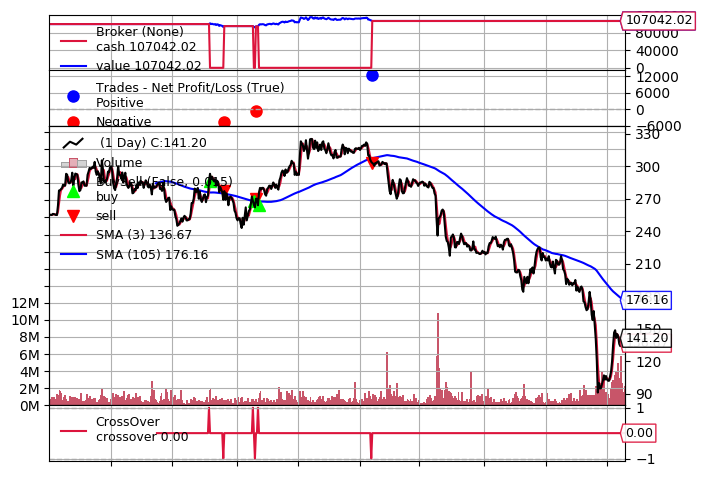

In [30]:
cerebro = backtest('smac', 
                   dcv_data, 
                   fast_period=best_fast_period, 
                   slow_period=best_slow_period, 
                   verbose=True, 
                   plot=True
                  )
cerebro.broker.get_value()

There are only 6 cross-over events of which the latter transactions yielded positive gains resulting to a 7% net profit. Is 7% profit over a ~two-year baseline better than the market benchmark?

## Final notes

While it is tempting to do a grid search over larger search space and finer resolutions, it is computationally expensive, inefficient, and prone to overfitting. There are better methods than brute force grid search which we will tackle in the next example.

As an exercise, it is good to try the following:
* Use different trading strategies and compare their results
* Use a longer data baseline